# Title: EDA on Combined Medical Q&A Dataset
## Description: Basic and advanced EDA on the merged MedQuad + iCliniq data.
### Author: Bernard Kyei-Mensah


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import missingno as msno
from pymongo import MongoClient
from datetime import datetime, UTC


In [2]:
viz_path = '../data/logs/'

In [3]:
# MongoDB Connection
client = MongoClient("mongodb://localhost:27017/")
db = client["medimaven_db"]
medical_qa_collection = db["qa_master_raw"]

In [4]:
def load_data_from_mongo():
    """Fetch medical Q&A data from MongoDB and load it into a pandas DataFrame."""
    cursor = medical_qa_collection.find({}, {"_id": 0})  # Exclude _id for cleaner output
    df = pd.DataFrame(list(cursor))
    return df

In [5]:
df = load_data_from_mongo()
df

,Dataset,focus,synonyms,qtype,question,context,answer,speciality,tags,created_at,updated_at
0,MedQuad,keratoderma with woolly hair,KWWH,information,What is are keratoderma with woolly hair ?,KWWH keratoderma with woolly hair What is are ...,Keratoderma with woolly hair is a group of rel...,,[],2025-03-03 02:36:45.839,2025-03-03 02:36:45.839
1,MedQuad,keratoderma with woolly hair,KWWH,frequency,How many people are affected by keratoderma wi...,KWWH keratoderma with woolly hair How many peo...,Keratoderma with woolly hair is rare its preva...,,[],2025-03-03 02:36:45.839,2025-03-03 02:36:45.839
2,MedQuad,keratoderma with woolly hair,KWWH,genetic changes,What are the genetic changes related to kerato...,KWWH keratoderma with woolly hair What are the...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen...",,[],2025-03-03 02:36:45.839,2025-03-03 02:36:45.839
3,MedQuad,keratoderma with woolly hair,KWWH,inheritance,Is keratoderma with woolly hair inherited ?,KWWH keratoderma with woolly hair Is keratoder...,Most cases of keratoderma with woolly hair hav...,,[],2025-03-03 02:36:45.839,2025-03-03 02:36:45.839
4,MedQuad,keratoderma with woolly hair,KWWH,treatment,What are the treatments for keratoderma with w...,KWWH keratoderma with woolly hair What are the...,These resources address the diagnosis or manag...,,[],2025-03-03 02:36:45.839,2025-03-03 02:36:45.839
...,...,...,...,...,...,...,...,...,...,...,...
64793,iCliniQ,,,,I am not gaining weight. Please guide me if I ...,"Hi doctor,\nI am 24 years old male. For the pa...","Hello,Welcome to icliniq.com.First of all, che...",Neurology,[],2025-03-03 02:36:45.870,2025-03-03 02:36:45.870
64794,iCliniQ,,,,Do I need treatment for premature ejaculation?,"Hello doctor,\nI am 37 years old, a gynecologi...","Hello,\nWelcome to icliniq.com.\nNo, it is not...",Cardiology,[],2025-03-03 02:36:45.870,2025-03-03 02:36:45.870
64795,iCliniQ,,,,I had unprotected sex. What are my chances of ...,"Hello doctor,\nI had unprotected sex with my b...","Hi,\nWelcome to icliniq.com.\nPlease do not be...",Obstetrics and Gynecology,[],2025-03-03 02:36:45.870,2025-03-03 02:36:45.870
64796,iCliniQ,,,,How many days after HIV do rashes appear?,"Hello doctor,\n15 days back, I met a girl and ...","Hello,\nWelcome to icliniq.com. A rash is a ve...",Dermatology,[],2025-03-03 02:36:45.870,2025-03-03 02:36:45.870


### QUICK INSPECTION

In [8]:

print("DataFrame shape:", df.shape)


DataFrame shape: (64798, 11)


#### 1. COLUMNS OVERVIEW

In [6]:

print("\nColumns:\n", df.columns)


Columns:
 Index(['Dataset', 'focus', 'synonyms', 'qtype', 'question', 'context',
       'answer', 'speciality'],
      dtype='object')


## **⚠️ Missing Values**
- **`synonyms` & `speciality`**: Notably higher missing rates, reflecting dataset-specific inconsistencies (e.g., MedQuad may omit synonyms, iCliniq may omit focus).
- **Possible Action**: Apply `fillna` or domain-specific strategies for empty fields (like synonyms or specialties).


Missing Value Summary:

Dataset           0
focus         48453
synonyms      53908
qtype         48439
question          0
context           0
answer            0
speciality    16473
dtype: int64


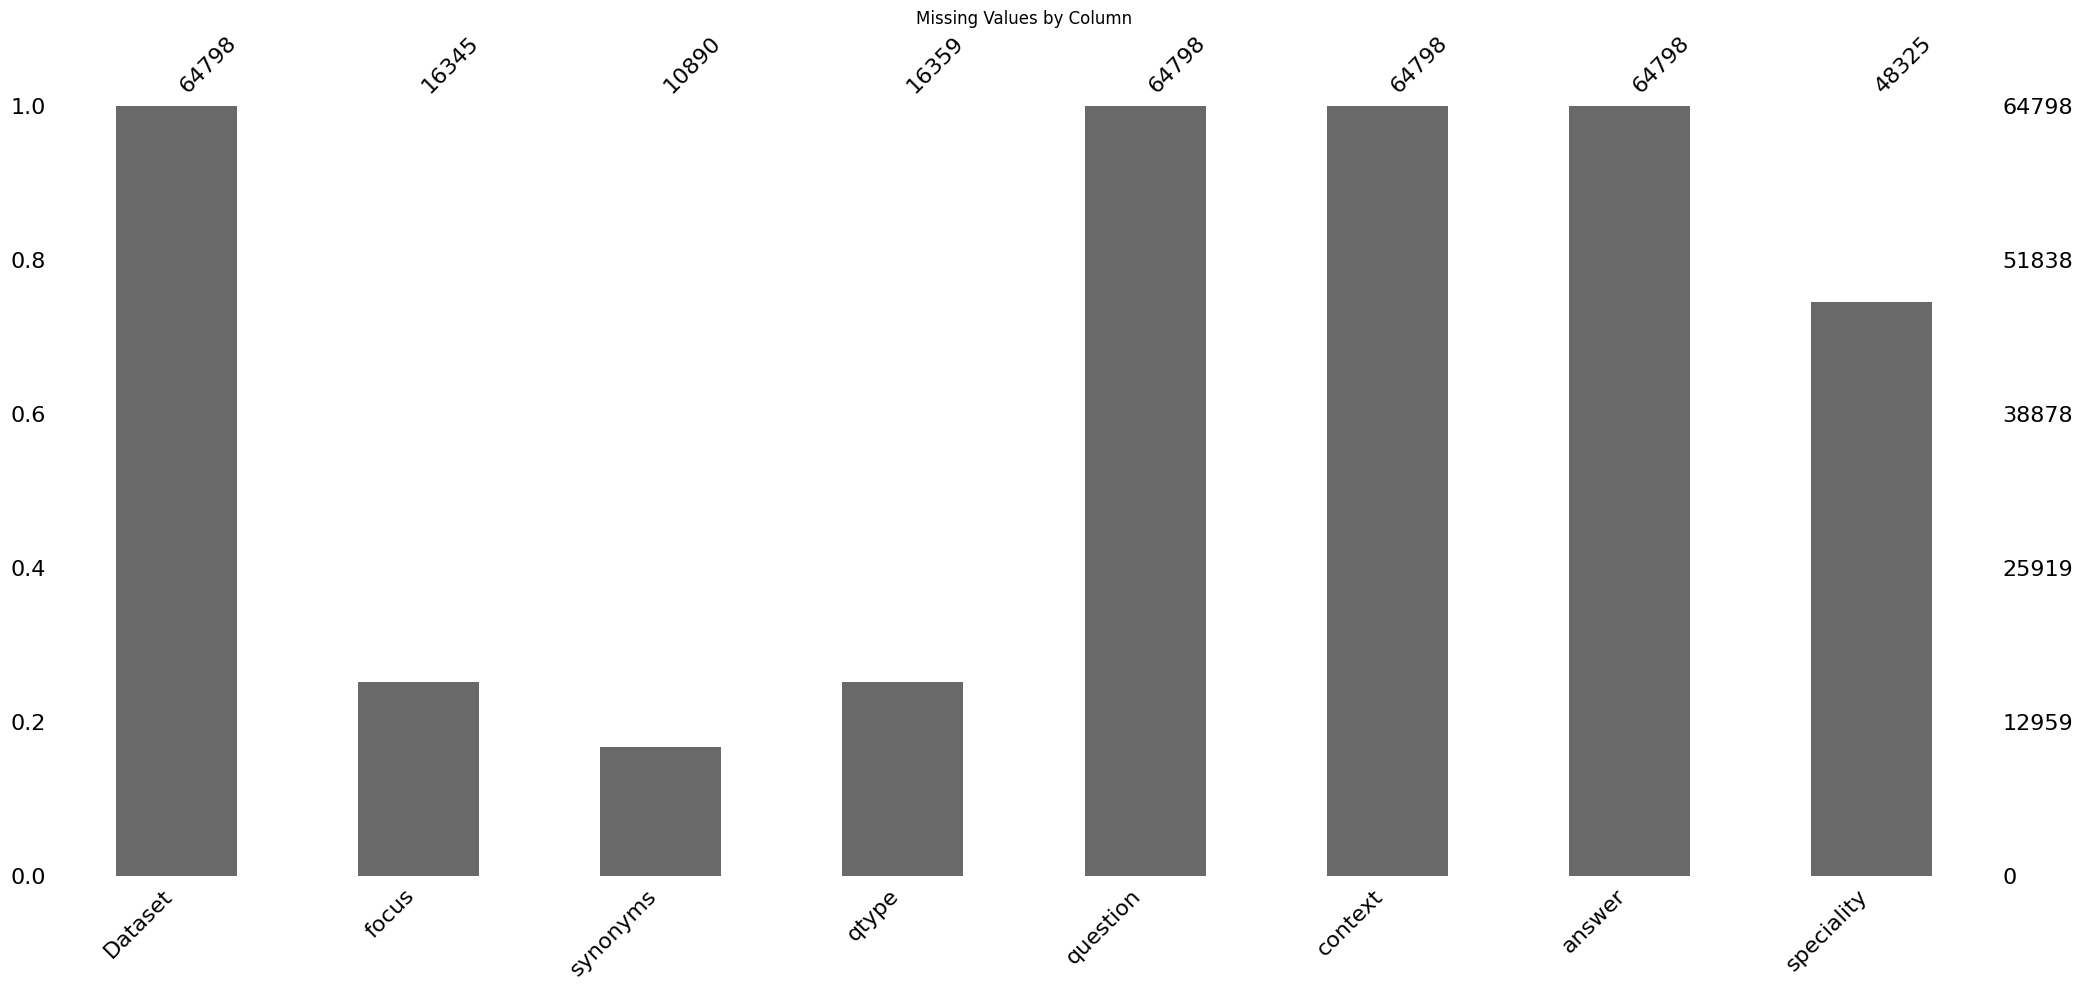

In [7]:

print("\nMissing Value Summary:\n")
print(df.isnull().sum())
plt.figure(figsize=(3,1))
msno.bar(df)
plt.title("Missing Values by Column")
plt.savefig(viz_path+'missing_values.png')
plt.show()


## **📊 Dataset Distribution**
- **Balanced Sources**: About 25% came from **MedQuad** while some 75% **iCliniq**


Dataset Distribution:
 Dataset
iCliniQ    48439
MedQuad    16359
Name: count, dtype: int64


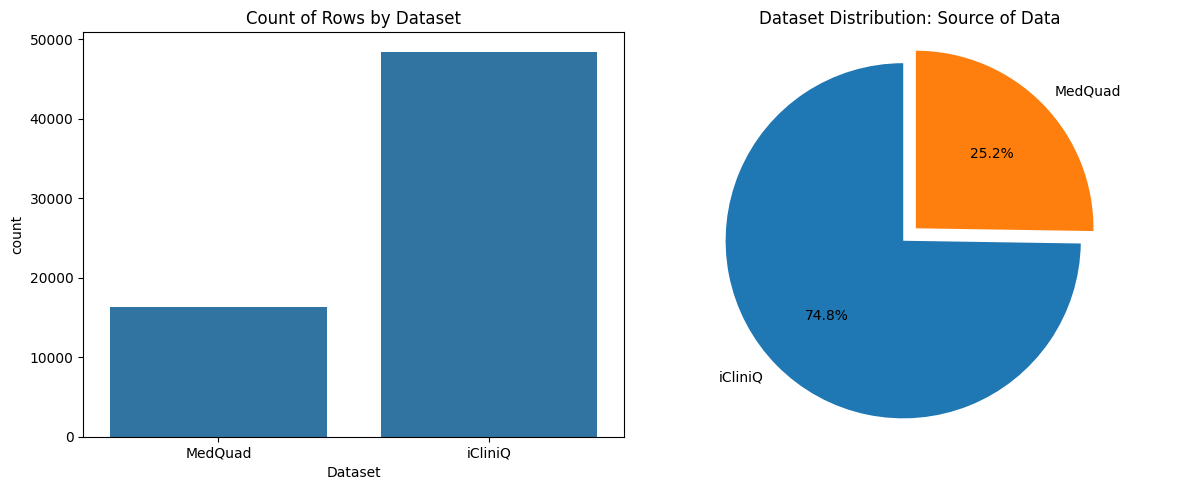

In [8]:
# 3. BASIC STATISTICS / DISTRIBUTIONS
# 3a. Distribution of 'Dataset'
dataset_counts = df['Dataset'].value_counts(dropna=False)
print("\nDataset Distribution:\n", dataset_counts)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ----- Bar Plot -----
sns.countplot(data=df, x='Dataset', ax=axs[0])
axs[0].set_title("Count of Rows by Dataset")

# ----- Pie Chart -----
explodes = [0.1, 0]  # Explode the first slice
axs[1].pie(dataset_counts, labels={i: j for i, j in dataset_counts.items()},
            autopct='%1.1f%%', startangle=90, explode=explodes)
axs[1].axis('equal')  # Ensure the pie chart is circular
axs[1].set_title('Dataset Distribution: Source of Data')

plt.tight_layout()
plt.savefig(viz_path+'dataset_distribution.png')
plt.show()

## **🩺 Top Specialties (iCliniq)**
- **Common Fields**: Cardiology, Neurology, Obstetrics & Gynecology, Dermatology.
- **Focus**: Shows user interest in broad medical areas.


Speciality Distribution:
 speciality
Obstetrics and Gynecology         5924
General Practitioner              4142
NaN                               4051
Internal Medicine                 3931
Dermatology                       3516
Psychiatry                        3025
Cardiology                        2480
Dentistry                         2438
Otolaryngology (E.N.T)            1592
Sexology                          1525
Venereology                       1494
Pediatrics                        1339
Pulmonology (Asthma Doctors)      1311
Neurology                         1284
Urology                           1277
Medical Gastroenterology          1253
Ophthalmology (Eye Care)          1206
Pathology                         1108
Orthopedician and Traumatology    1066
Family Physician                   881
Name: count, dtype: int64


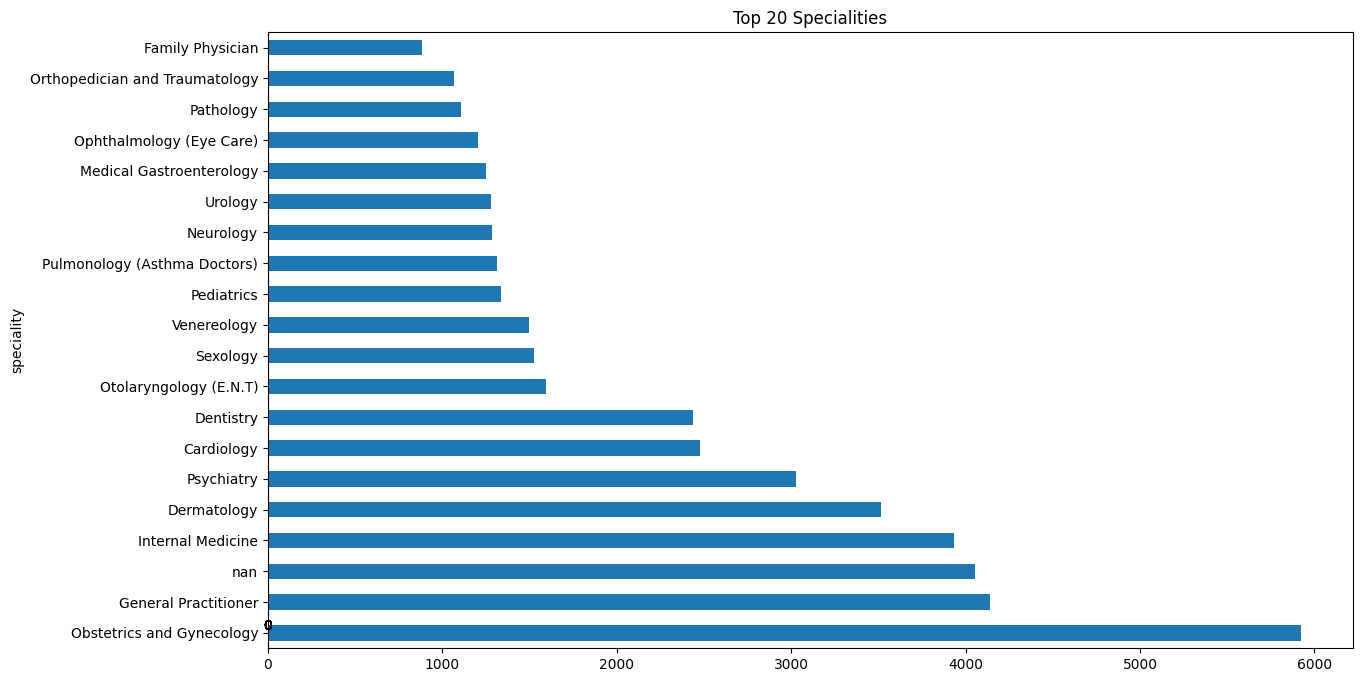

In [86]:
# 3b. Distribution of 'speciality'
speciality_counts = df['speciality'].value_counts(dropna=False)
print("\nSpeciality Distribution:\n", speciality_counts.head(20))  # top 10
plt.figure(figsize=(14, 8))
ax = speciality_counts.head(20).plot(kind='barh')
plt.title("Top 20 Specialities")

# Add count annotations on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f'{int(height)}',
                xy=(patch.get_x() + patch.get_width() / 2, height),
                xytext=(0, 0),  # 5 points vertical offset
                textcoords='data',
                ha='center', va='bottom')
plt.savefig(viz_path+'top_specialities.png')
plt.show()

## **📏 Question & Answer Length**
- **Question Length**: Averages around 120 characters. Short, direct queries are common.
- **Answer Length**: Averages around 700 characters. iCliniq responses often include detailed physician clarifications.
- **context Length**: Averages around 500 characters but also contains some outliers

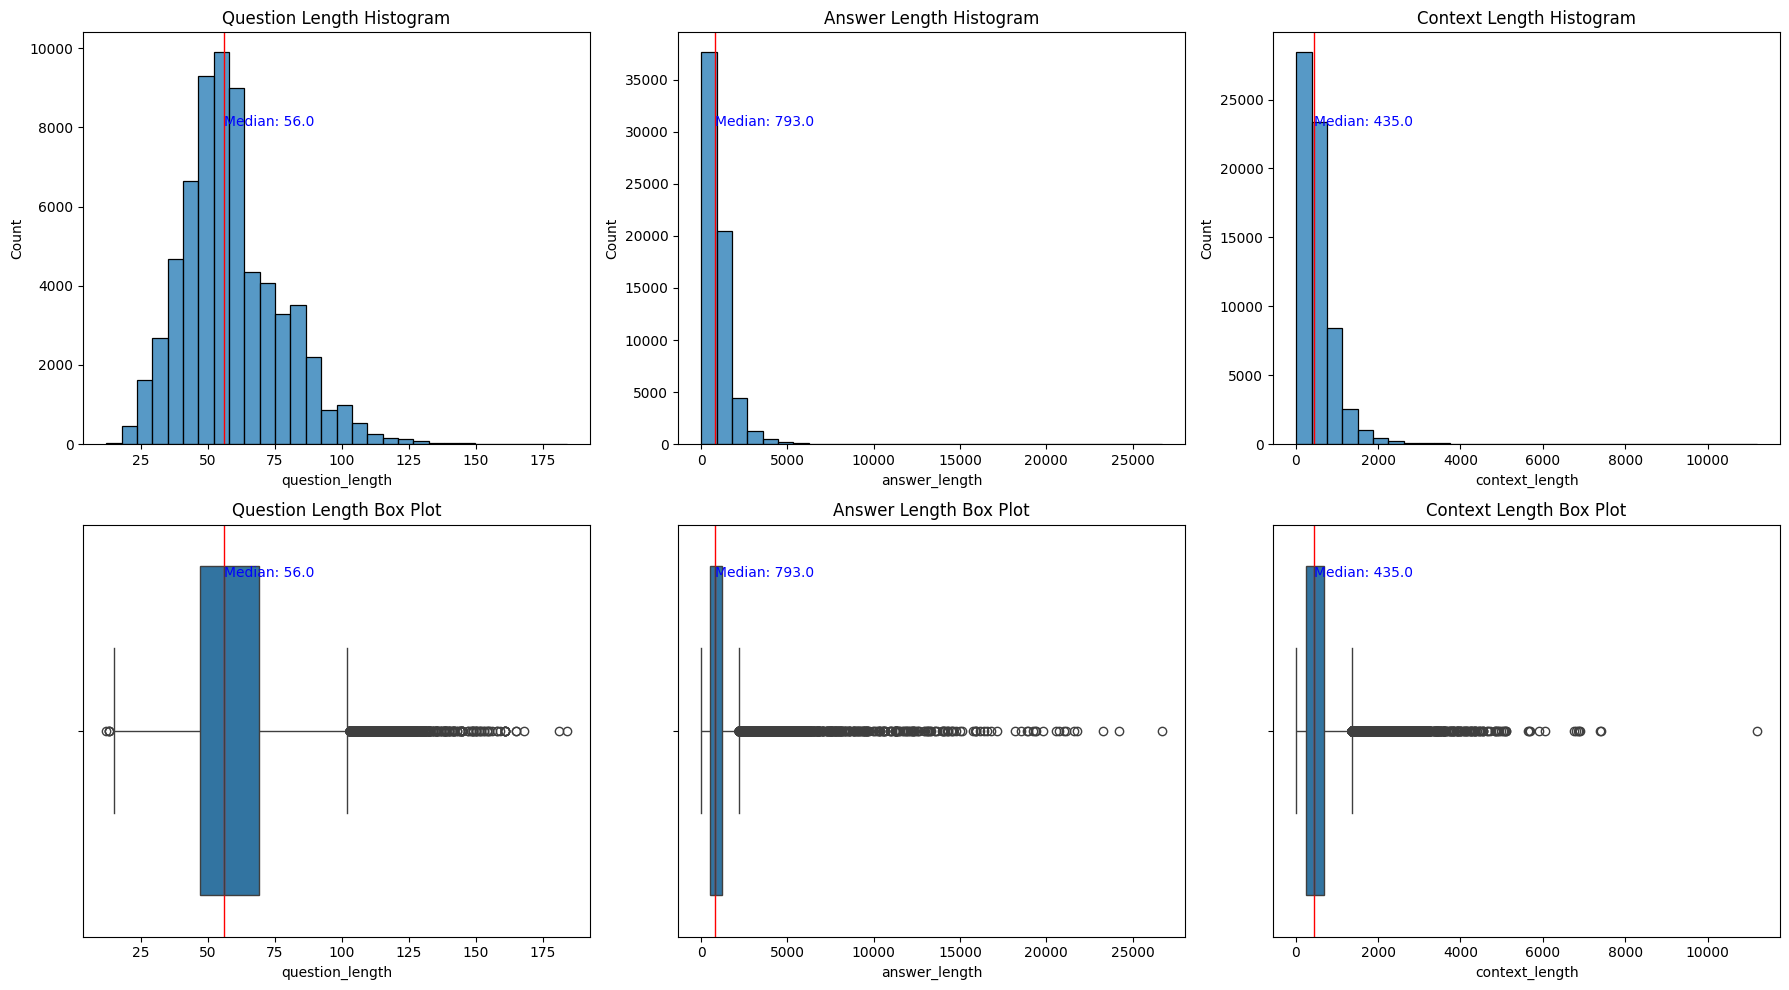

In [25]:
def add_stats(ax, data, color_mean='red', color_median='red'):
    mean_val = data.mean()
    median_val = data.median()
    # Draw vertical lines for mean and median
    ax.axvline(median_val, color=color_median, linewidth=1)
    # Annotate the lines near the top of the plot
    ylim = ax.get_ylim()[1]
    ax.text(median_val, ylim * 0.8, f'Median: {median_val:.1f}', color='b',
            va='top', ha='left')

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top row: Histogram plots
sns.histplot(data=df, x='question_length', ax=axes[0,0], bins=30, kde=False)
axes[0,0].set_title("Question Length Histogram")
add_stats(axes[0,0], df['question_length'])

sns.histplot(data=df, x='answer_length', ax=axes[0,1], bins=30, kde=False)
axes[0,1].set_title("Answer Length Histogram")
add_stats(axes[0,1], df['answer_length'])

sns.histplot(data=df, x='context_length', ax=axes[0,2], bins=30, kde=False)
axes[0,2].set_title("Context Length Histogram")
add_stats(axes[0,2], df['context_length'])

# Bottom row: Box plots (to highlight outliers)
sns.boxplot(x=df['question_length'], ax=axes[1,0])
axes[1,0].set_title("Question Length Box Plot")
add_stats(axes[1,0], df['question_length'])

sns.boxplot(x=df['answer_length'], ax=axes[1,1])
axes[1,1].set_title("Answer Length Box Plot")
add_stats(axes[1,1], df['answer_length'])

sns.boxplot(x=df['context_length'], ax=axes[1,2])
axes[1,2].set_title("Context Length Box Plot")
add_stats(axes[1,2], df['context_length'])


plt.tight_layout()
plt.savefig(viz_path+'distribution_of_lengths.png')
plt.show()

In [ ]:
#Qestions Less than 5 characters
# We can see questions with a length less than 5 are still good
df[df['question'].str.split().str.len()< 5].question

13                    Is coloboma inherited ?
28               Is pilomatricoma inherited ?
148            Is globozoospermia inherited ?
423              Is citrullinemia inherited ?
448                  Is cherubism inherited ?
                         ...                 
64233             How to fix procrastination?
64301              Is polydactyly hereditary?
64349               Will sex trigger periods?
64481            Is midline diastema curable?
64554    Does teratospermia mean infertility?
Name: question, Length: 535, dtype: object

In [32]:
df[df['answer'].str.split().str.len()< 5].answer

9905      Is Williams syndrome inherited?
14949                              Topics
15137    Frequently Asked Queestions FAQs
15158    Frequently Asked Queestions FAQs
22281                                test
36691     Hello,\nWelcome to icliniq.com.
37480          Hi,Welcome to icliniq.com.
38295     Hello,\nWelcome to icliniq.com.
42957          Hi,Welcome to icliniq.com.
44794        Hi,\nWelcome to icliniq.com.
54701          Hi,Welcome to icliniq.com.
56568        Hi,\nWelcome to icliniq.com.
59846     Hello,\nWelcome to icliniq.com.
Name: answer, dtype: object

In [39]:
# dropping the above linees because they make no sense
drop_indices = df[df['answer'].str.split().str.len() < 6].index
df.drop(drop_indices, inplace=True)

In [42]:
#we're gonna leave it at 7
df[df['answer'].str.split().str.len()< 7].answer

3476         The prevalence of erythromelalgia is unknown.
3506                    The prevalence of BPES is unknown.
3756           The incidence of hyperlysinemia is unknown.
3846             The prevalence of monilethrix is unknown.
4746              The prevalence of piebaldism is unknown.
5715     How is oculopharyngeal muscular dystrophy inhe...
6718          Is Wolff Parkinson White syndrome inherited?
8871        How is Pelizaeus Merzbacher disease inherited?
11017              Agnosia can compromise quality of life.
15007          Frequently Asked Questions FAQs Fact Sheets
15049      General guidelines for safe seafood consumption
15072    Frequently Asked Questions FAQs Vector Informa...
16224              Urine leakage has many possible causes.
Name: answer, dtype: object

In [64]:
df[df['context'].str.split().str.len()< 25].context

0        KWWH keratoderma with woolly hair What is are ...
1        KWWH keratoderma with woolly hair How many peo...
2        KWWH keratoderma with woolly hair What are the...
3        KWWH keratoderma with woolly hair Is keratoder...
4        KWWH keratoderma with woolly hair What are the...
                               ...                        
64756    Hi doctor,\nMy sister is diagnosed with IDC me...
64761    Hi doctor,\nI have acne for the past one year....
64762    Hi doctor,\nI had a history of thyroid issue b...
64784    Hello doctor,I do masturbation in a week and m...
64785    Hi doctor,\nI have PCOD for the past one year....
Name: context, Length: 11342, dtype: object

In [65]:
# dropping the above linees because they make no sense
drop_indices = df[df['context'].str.split().str.len() < 24].index
df.drop(drop_indices, inplace=True)

In [10]:
df['context_length']   = df['context'].astype(str).apply(len)

In [84]:
# 5. FREQUENCY OF FOCUS & QTYPE
focus_counts = df['focus'].value_counts(dropna=False)
qtype_counts = df['qtype'].value_counts(dropna=False)
print("\nFocus Frequency:\n", focus_counts.head())
print("\nQType Frequency:\n", qtype_counts.head())



Focus Frequency:
 focus
                   48453
Breast Cancer         53
Prostate Cancer       43
Stroke                35
Skin Cancer           34
Name: count, dtype: int64

QType Frequency:
 qtype
               48439
information     4520
symptoms        2747
treatment       2440
inheritance     1446
Name: count, dtype: int64


## **💡 Text-Based Observations**
- **Frequent Keywords**: "cause", “symptoms,” “treatment,” “pain,” reason,” “complications.”
- **WordCloud (INSERT)** reveals prevalent medical terms across queries.

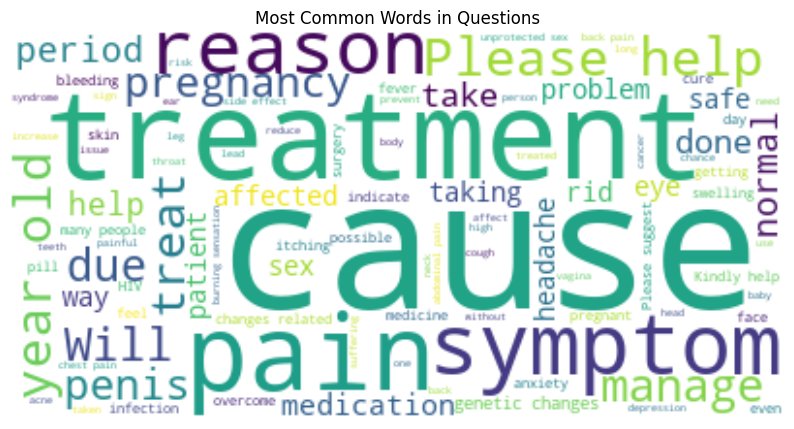

In [87]:
# 6. TEXT-BASED EDA
# Example: WordCloud of the most common words in 'question'
all_questions = " ".join(df['question'].dropna().astype(str).values)
wordcloud = WordCloud(background_color="white", max_words=100).generate(all_questions)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Questions")
plt.savefig(viz_path+'key_words.png')

plt.show()

# **🔗 Correlation**
- **Lengths**: Moderate correlation (~0.4–0.5) between question & answer length; longer questions often elicit more detailed answers.
- **Data Type**: Mostly textual, so numeric correlations are less informative beyond length.


Correlation matrix (length columns):
                  question_length  answer_length
question_length         1.000000      -0.043697
answer_length          -0.043697       1.000000


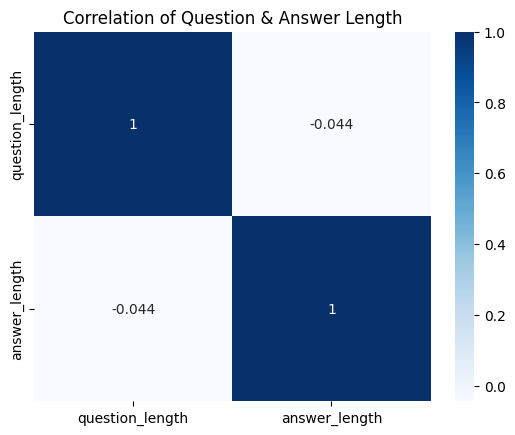

In [88]:
# 7. CORRELATIONS OR ANY ADVANCED STATS (Optional)
# Because columns are largely categorical and text-based, correlations might not be too meaningful,
# but we can do an example using length columns.

corr_matrix = df[['question_length','answer_length']].corr()
print("\nCorrelation matrix (length columns):\n", corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Correlation of Question & Answer Length")
plt.savefig(viz_path+'distribution_of_lengths.png')
plt.savefig(viz_path+'corelation.png')
plt.show()

In [1]:
try:
    import airflow
    print("Airflow is installed!")
    print("Airflow version:", airflow.__version__)
except ImportError:
    print("Airflow is not installed.")

TypeError: 'module' object is not callable

In [1]:
import airflow

TypeError: 'module' object is not callable

In [2]:
from zenml.client import Client

artifact = Client().get_artifact_version("d47a7703-d3cd-4d0a-abd1-d4427c8c3c84")
data = artifact.load()
data

By default, the PandasMaterializer stores data as a .csv file. If you want to store data more efficiently, you can install pyarrow by running 'pip install pyarrow'. This will allow PandasMaterializer to automatically store the data as a .parquet file instead.


/opt/homebrew/Caskroom/miniconda/base/envs/MediMaven/lib/python3.12/site-packages/zenml/integrations/pandas/materializers/pandas_materializer.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, index_col=0, parse_dates=True)


,Dataset,focus,synonyms,qtype,question,context,answer,speciality,tags,created_at,updated_at,context_length
0,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",information,"What is are T cell immunodeficiency, congenita...","alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",NaN,[],2025-03-03 03:41:54.991,2025-03-03 03:41:54.991,324
1,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",frequency,How many people are affected by T cell immunod...,"alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",NaN,[],2025-03-03 03:41:54.991,2025-03-03 03:41:54.991,344
2,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",genetic changes,What are the genetic changes related to T cell...,"alymphoid cystic thymic dysgenesis,congenital ...","T cell immunodeficiency, congenital alopecia, ...",NaN,[],2025-03-03 03:41:54.991,2025-03-03 03:41:54.991,352
3,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",inheritance,"Is T cell immunodeficiency, congenital alopeci...","alymphoid cystic thymic dysgenesis,congenital ...",This condition is inherited in an autosomal re...,NaN,[],2025-03-03 03:41:54.991,2025-03-03 03:41:54.991,325
4,MedQuad,"T-cell immunodeficiency, congenital alopecia, ...","alymphoid cystic thymic dysgenesis,congenital ...",treatment,What are the treatments for T cell immunodefic...,"alymphoid cystic thymic dysgenesis,congenital ...",These resources address the diagnosis or manag...,NaN,[],2025-03-03 03:41:54.991,2025-03-03 03:41:54.991,340
...,...,...,...,...,...,...,...,...,...,...,...,...
52006,iCliniQ,NaN,NaN,NaN,I am not gaining weight. Please guide me if I ...,"Hi doctor,\nI am 24 years old male. For the pa...","Hello,Welcome to icliniq.com.First of all, che...",Neurology,[],2025-03-03 03:41:55.009,2025-03-03 03:41:55.009,401
52007,iCliniQ,NaN,NaN,NaN,Do I need treatment for premature ejaculation?,"Hello doctor,\nI am 37 years old, a gynecologi...","Hello,\nWelcome to icliniq.com.\nNo, it is not...",Cardiology,[],2025-03-03 03:41:55.009,2025-03-03 03:41:55.009,600
52008,iCliniQ,NaN,NaN,NaN,I had unprotected sex. What are my chances of ...,"Hello doctor,\nI had unprotected sex with my b...","Hi,\nWelcome to icliniq.com.\nPlease do not be...",Obstetrics and Gynecology,[],2025-03-03 03:41:55.009,2025-03-03 03:41:55.009,653
52009,iCliniQ,NaN,NaN,NaN,How many days after HIV do rashes appear?,"Hello doctor,\n15 days back, I met a girl and ...","Hello,\nWelcome to icliniq.com. A rash is a ve...",Dermatology,[],2025-03-03 03:41:55.009,2025-03-03 03:41:55.009,1221
